Imports

In [105]:
# imports ..
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt


Read the dataset

In [115]:
data_folder = './data/'
train_file = f'{data_folder}training_v2.csv'

train_df = pd.read_csv(train_file)

train_df.head(5)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


Explore the data

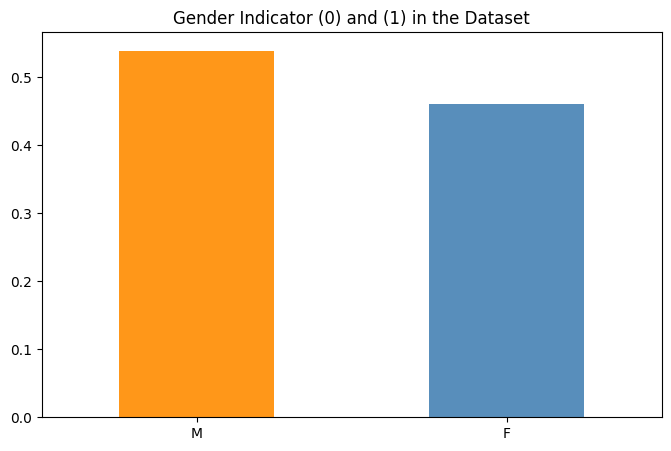

In [118]:
# explore male - female ratio
fig = plt.figure(figsize = (8,5))
train_df.gender.value_counts(normalize = True).plot(kind='bar', color= ['darkorange','steelblue'], alpha = 0.9, rot=0)
plt.title('Gender Indicator (0) and (1) in the Dataset')
plt.show()

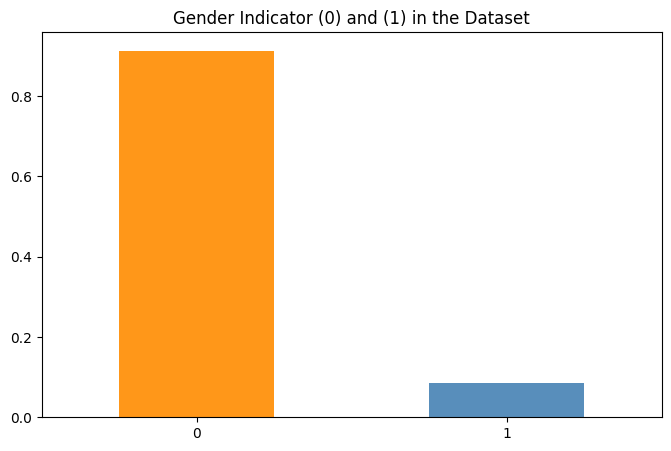

In [119]:
# explore survived - died ratio
fig = plt.figure(figsize = (8,5))
train_df.hospital_death.value_counts(normalize = True).plot(kind='bar', color= ['darkorange','steelblue'], alpha = 0.9, rot=0)
plt.title('Gender Indicator (0) and (1) in the Dataset')
plt.show()

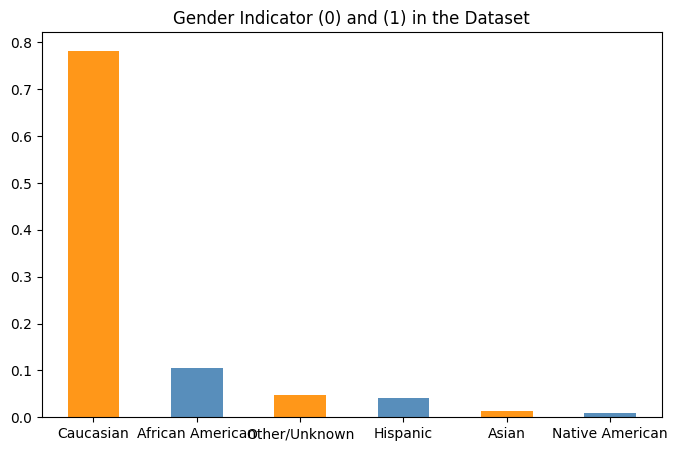

In [120]:
# explore ethnicity 
fig = plt.figure(figsize = (8,5))
train_df.ethnicity.value_counts(normalize = True).plot(kind='bar', color= ['darkorange','steelblue'], alpha = 0.9, rot=0)
plt.title('Gender Indicator (0) and (1) in the Dataset')
plt.show()

Handle nans

In [84]:
# check how many nulls are present
total_na = train_df.isna().sum().sum()
total_null = train_df.isnull().sum().sum()
total_na + total_null

11486984

In [85]:
# remove nulls - for continues values use mean, for discrete use mode

for column in list(train_df.columns):
    value_to_insert = None
    if train_df[column].dtype == float:
        #print(f'float value found! at: {column}')
        value_to_insert = train_df[column].mean()        
    else:
        value_to_insert = train_df[column].mode()[0]
    #print(f'column: {column}, replacing value: {value_to_insert}')
    train_df[column].fillna(value_to_insert, inplace=True)

total_na = train_df.isna().sum().sum()
total_null = train_df.isnull().sum().sum()
assert total_na == 0 and total_null == 0

Data transformation

In [86]:
# get all columns where the values are strings
string_columns = train_df.select_dtypes(include=[object])
string_columns_names = list(string_columns.columns)

# replace these columns with their enumerated value
for column_name in string_columns_names:    
    enumerated_unique_values = list(enumerate(string_columns[column_name].unique()))
    value_to_index_mapper = dict([(y,x) for x,y in enumerated_unique_values])
    train_df[column_name].replace(value_to_index_mapper, inplace=True)

# make sure no string columns are left
assert len(train_df.select_dtypes(include=[object]).columns) == 0

Add features

In [101]:
# columns in use
hospital_id_column_name = 'hospital_id'
patient_count_column_name = 'hospital_visit_count'
hospital_death_col_name = 'hospital_death'
hospital_death_count_col_name = 'hospital_death_count'
percent_of_deaths_col_name = 'percent_of_deaths_in_hospital'

In [102]:
# add feature counting how many visits were at a hospital

train_df[patient_count_column_name] = train_df.groupby(hospital_id_column_name)[hospital_id_column_name].transform('size')
train_df[[hospital_id_column_name, patient_count_column_name]]

,hospital_id,hospital_visit_count
0,118,4333
1,81,580
2,118,4333
3,118,4333
4,33,323
...,...,...
91708,30,515
91709,121,121
91710,195,215
91711,66,22


In [103]:
# count how many deaths were recorded for each hospital

train_df[hospital_death_count_col_name] = train_df.groupby(hospital_id_column_name)[hospital_death_col_name].transform('sum')
train_df[[hospital_id_column_name,hospital_death_count_col_name]]

,hospital_id,hospital_death_count
0,118,306
1,81,25
2,118,306
3,118,306
4,33,9
...,...,...
91708,30,24
91709,121,5
91710,195,12
91711,66,0


In [104]:
# get the percent of deaths among visits in a hospital

train_df[percent_of_deaths_col_name] = train_df.apply(lambda row: round(row[hospital_death_count_col_name] / row[patient_count_column_name], 4), axis=1)
train_df[[percent_of_deaths_col_name]]

,percent_of_deaths_in_hospital
0,0.0706
1,0.0431
2,0.0706
3,0.0706
4,0.0279
...,...
91708,0.0466
91709,0.0413
91710,0.0558
91711,0.0000


Get rid of columns that contains ID

In [89]:
df = df[df.columns.drop(list(df.filter(regex='_id')))]

NameError: name 'df' is not defined